# 📊 Face Expression System with Multiple Classifiers and CNN

## 🧼 Step 1: Preprocess Images and Store

In [8]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:


IMG_SIZE = 48
SOURCE_FOLDER = 'dataset'
DEST_FOLDER = 'dataset_preprocessed_gray'
CATEGORIES = ['face', 'no_face']

def add_noise(image):
    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def augment_and_save(img, base_name, save_dir):
    # 1. Horizontal Flip
    flipped = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(save_dir, f"{base_name}_flip.jpg"), flipped)

    # 2. Rotate (+15 degrees)
    h, w = img.shape
    M1 = cv2.getRotationMatrix2D((w//2, h//2), 15, 1)
    rotated1 = cv2.warpAffine(img, M1, (w, h))
    cv2.imwrite(os.path.join(save_dir, f"{base_name}_rot15.jpg"), rotated1)

    # 3. Rotate (-15 degrees)
    M2 = cv2.getRotationMatrix2D((w//2, h//2), -15, 1)
    rotated2 = cv2.warpAffine(img, M2, (w, h))
    cv2.imwrite(os.path.join(save_dir, f"{base_name}_rot-15.jpg"), rotated2)

    # 4. Gaussian Blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    cv2.imwrite(os.path.join(save_dir, f"{base_name}_blur.jpg"), blurred)

    # 5. Add Noise
    noised = add_noise(img)
    cv2.imwrite(os.path.join(save_dir, f"{base_name}_noise.jpg"), noised)

if not os.path.exists(DEST_FOLDER):
    os.makedirs(DEST_FOLDER)

for category in CATEGORIES:
    src_path = os.path.join(SOURCE_FOLDER, category)
    dst_path = os.path.join(DEST_FOLDER, category)

    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

    # Skip if already processed
    if len(os.listdir(dst_path)) > 0:
        print(f"Skipping preprocessing for '{category}' - already processed.")
        continue

    for img_name in os.listdir(src_path):
        try:
            img_path = os.path.join(src_path, img_name)
            img = cv2.imread(img_path)

            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize
            gray_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))

            # Save original
            base_name = os.path.splitext(img_name)[0]
            cv2.imwrite(os.path.join(dst_path, f"{base_name}_orig.jpg"), gray_img)

            # Create and save augmented versions
            augment_and_save(gray_img, base_name, dst_path)

        except Exception as e:
            print(f"Error processing {img_name}: {e}")


Skipping preprocessing for 'face' - already processed.
Skipping preprocessing for 'no_face' - already processed.


In [6]:

# ------------------------
# 1. Feature Extractor Builder
# ------------------------
def build_feature_extractor(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten()
    ])
    return model

# ------------------------
# 2. Full CNN Classifier Head
# ------------------------
def build_cnn_classifier(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(shape=input_shape)
    feature_extractor = build_feature_extractor(input_shape)
    features = feature_extractor(inputs)
    x = Dense(128, activation='relu')(features)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


# ------------------------
# 3. Load Data
# ------------------------
data = []
for category in CATEGORIES:
    path = os.path.join(DEST_FOLDER, category)
    label = CATEGORIES.index(category)
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img, label])
        except:
            continue

random.shuffle(data)

X = np.array([item[0] for item in data]) / 255.0  # Normalize
y = np.array([item[1] for item in data])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ------------------------
# 4. Feature Extraction for SVM / Logistic Regression
# ------------------------
extractor = build_feature_extractor()
extractor.summary()

features_train = extractor.predict(X_train)
features_test = extractor.predict(X_test)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

joblib.dump(scaler, "models/feature_scaler.pkl")
extractor.save("models/feature_extractor.h5")
  

# # Load Data
# data = []
# for category in CATEGORIES:
#     path = os.path.join(DEST_FOLDER, category)
#     label = CATEGORIES.index(category)
#     for img_name in os.listdir(path):
#         try:
#             img_path = os.path.join(path, img_name)
#             img = cv2.imread(img_path)
#             img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#             data.append([img, label])
#         except:
#             continue

# random.shuffle(data)

# # Prepare X and y
# X = np.array([item[0] for item in data]) / 255.0  # Normalize
# y = np.array([item[1] for item in data])

# # Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Feature Extractor (CNN without Dense)
# extractor = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     MaxPooling2D(2,2),
#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(2,2),
#     Flatten()
# ])
# extractor.summary()

# # Extract features
# features_train = extractor.predict(X_train)
# features_test = extractor.predict(X_test)

# # Normalize features
# scaler = StandardScaler()
# features_train = scaler.fit_transform(features_train)
# features_test = scaler.transform(features_test)
# joblib.dump(scaler, "models/feature_scaler.pkl")
# extractor.save("models/feature_extractor.h5")

C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## 🤖 Step 2: Train SVM, Logistic, and Sigmoid NN on Extracted Features

In [4]:

# ------------------------
# 5. SVM Classifier
# ------------------------
svm = SVC(kernel='linear')
svm.fit(features_train, y_train)
svm_pred = svm.predict(features_test)
svm_acc = accuracy_score(y_test, svm_pred)
joblib.dump(svm, "models/svm_face_model.pkl")

# ------------------------
# 6. Logistic Regression Classifier
# ------------------------
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(features_train, y_train)
log_pred = log_reg.predict(features_test)
log_acc = accuracy_score(y_test, log_pred)
joblib.dump(log_reg, "models/logreg_face_model.pkl")


# # 1. SVM
# svm = SVC(kernel='linear')
# svm.fit(features_train, y_train)
# joblib.dump(svm, "models/svm_face_model.pkl")
# svm_pred = svm.predict(features_test)
# svm_acc = accuracy_score(y_test, svm_pred)

# # 2. Logistic Regression
# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(features_train, y_train)
# joblib.dump(log_reg, "models/logreg_face_model.pkl")
# log_pred = log_reg.predict(features_test)
# log_acc = accuracy_score(y_test, log_pred)

# # 3. MLP (Sigmoid)
# cnn_model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#     MaxPooling2D(pool_size=(2,2)),

#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Sigmoid for binary classification
# ])

# cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# cnn_model.summary()

# # Train CNN Model
# cnn_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
# cnn_model.save("models/cnn_face_model.h5")
# cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test)

# # Show accuracies
# print("--- ACCURACIES ---")
# print("SVM Accuracy:", svm_acc)
# print("Logistic Regression Accuracy:", log_acc)
# print(f"CNN (Sigmoid) Accuracy: {cnn_acc:.4f}")


['models/logreg_face_model.pkl']

In [6]:
# ------------------------
# 7. CNN Classifier (End-to-End)
# ------------------------
cnn_model = build_cnn_classifier()
cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test)
cnn_model.save("models/cnn_face_model.h5")

# ------------------------
# 8. Final Accuracy Report
# ------------------------
print("--- ACCURACIES ---")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"CNN (Sigmoid) Accuracy: {cnn_acc:.4f}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 6400)                │          19,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,849 (3.20 MB)

 Trainable params: 838,849 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7758 - loss: 0.4604 - val_accuracy: 0.9049 - val_loss: 0.2388
Epoch 2/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9003 - loss: 0.2320 - val_accuracy: 0.9192 - val_loss: 0.1953
Epoch 3/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9300 - loss: 0.1741 - val_accuracy: 0.9496 - val_loss: 0.1377
Epoch 4/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9522 - loss: 0.1287 - val_accuracy: 0.9610 - val_loss: 0.1115
Epoch 5/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9664 - loss: 0.0950 - val_accuracy: 0.9563 - val_loss: 0.1076
Epoch 6/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9708 - loss: 0.0762 - val_accuracy: 0.9667 - val_loss: 0.1027
Epoch 7/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9798 - loss: 0.0550 - val_accuracy: 0.9534 - val_loss: 0.1263
Epoch 8/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9870 - loss: 0.0384 - val_accu

--- ACCURACIES ---
SVM Accuracy: 0.9300
Logistic Regression Accuracy: 0.9384
CNN (Sigmoid) Accuracy: 0.9776


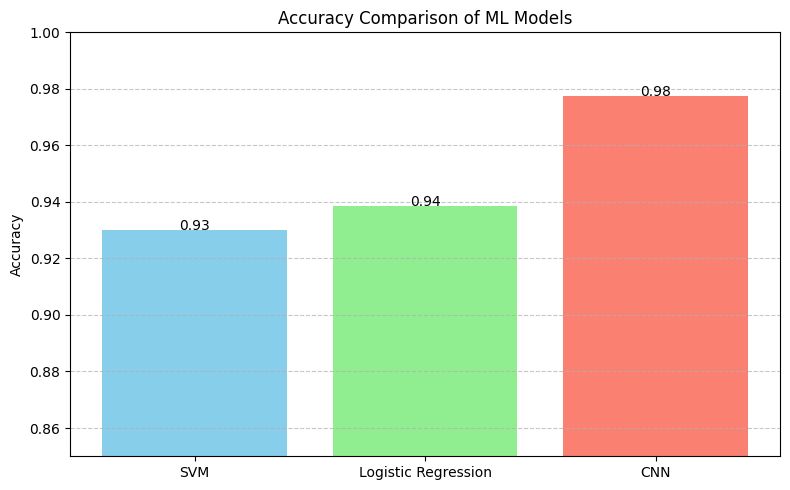

In [7]:
import matplotlib.pyplot as plt

# Accuracy values
model_names = ['SVM', 'Logistic Regression', 'CNN']
accuracies = [svm_acc, log_acc, cnn_acc]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0.85, 1.0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', fontsize=10)

plt.title('Accuracy Comparison of ML Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--- SVM ---
Accuracy: 0.9300380228136882
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1629
           1       0.91      0.90      0.91      1001

    accuracy                           0.93      2630
   macro avg       0.93      0.92      0.93      2630
weighted avg       0.93      0.93      0.93      2630

Confusion Matrix:


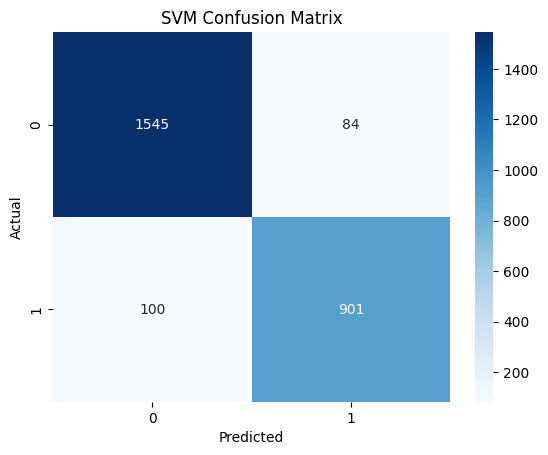

--- Logistic Regression ---
Accuracy: 0.938403041825095
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1629
           1       0.92      0.92      0.92      1001

    accuracy                           0.94      2630
   macro avg       0.94      0.93      0.93      2630
weighted avg       0.94      0.94      0.94      2630

Confusion Matrix:


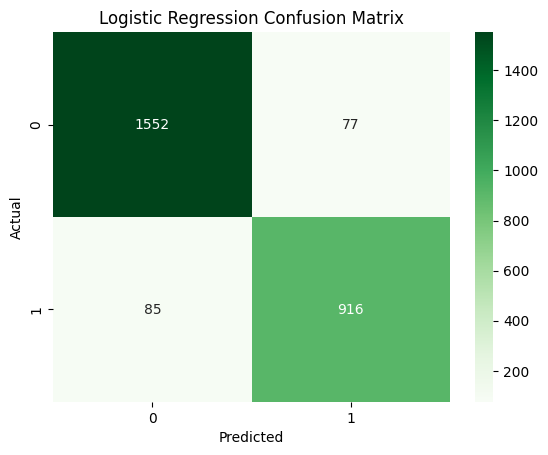

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
--- CNN (Sigmoid) ---
Accuracy: 0.9776
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1629
           1       0.97      0.97      0.97      1001

    accuracy                           0.98      2630
   macro avg       0.98      0.98      0.98      2630
weighted avg       0.98      0.98      0.98      2630

Confusion Matrix:


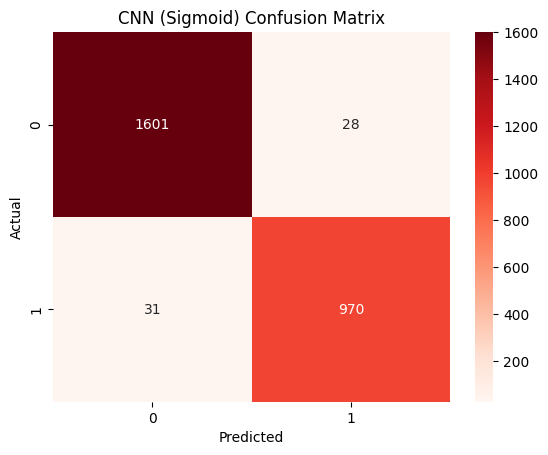

In [8]:
print("--- SVM ---")
print("Accuracy:", svm_acc)
print("Classification Report:")
print(classification_report(y_test, svm_pred))
print("Confusion Matrix:")
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -------------------------------
# Logistic Regression Evaluation
print("--- Logistic Regression ---")
print("Accuracy:", log_acc)
print("Classification Report:")
print(classification_report(y_test, log_pred))
print("Confusion Matrix:")
log_cm = confusion_matrix(y_test, log_pred)
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -------------------------------
# CNN Evaluation
# Predict class probabilities
cnn_probs = cnn_model.predict(X_test)
cnn_pred = (cnn_probs > 0.5).astype("int32").flatten()

print("--- CNN (Sigmoid) ---")
print(f"Accuracy: {cnn_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, cnn_pred))
print("Confusion Matrix:")
cnn_cm = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Reds')
plt.title('CNN (Sigmoid) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 🧑‍💻 Step 3: Face Recognition

In [14]:
IMG_SIZE = 48
DATA_DIR = 'dataset_preprocessed_gray/face'

images, labels = [], []
for fname in os.listdir(DATA_DIR):
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue
    user_id = fname.split('_')[0]
    path = os.path.join(DATA_DIR, fname)
    img  = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img  = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # convert to 3-channel if building a 3-channel CNN:
    img  = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    images.append(img)
    labels.append(user_id)

print(f"Total images loaded: {len(images)}")

Total images loaded: 8148


In [15]:
X = np.array(images, dtype="float32") / 255.0
y = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"Number of classes in face-recognition model: {num_classes}")

y_cat = to_categorical(y_encoded, num_classes=num_classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)
print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")


Number of classes in face-recognition model: 193
Training shape: (6518, 48, 48, 3), Testing shape: (1630, 48, 48, 3)


In [16]:
face_id_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

face_id_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
face_id_model.summary()


C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 193)                 │          49,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,707,649 (6.51 MB)

 Trainable params: 1,707,649 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = face_id_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

face_id_model.save("models/face_id_model.h5")
joblib.dump(label_encoder, "models/label_encoder.pkl")

Epoch 1/50
163/163 - 4s - 26ms/step - accuracy: 0.0510 - loss: 4.9448 - val_accuracy: 0.1304 - val_loss: 4.4667
Epoch 2/50
163/163 - 3s - 19ms/step - accuracy: 0.1787 - loss: 4.0300 - val_accuracy: 0.3044 - val_loss: 3.3141
Epoch 3/50
163/163 - 3s - 18ms/step - accuracy: 0.3333 - loss: 3.0046 - val_accuracy: 0.4762 - val_loss: 2.3779
Epoch 4/50
163/163 - 3s - 18ms/step - accuracy: 0.4810 - loss: 2.2030 - val_accuracy: 0.6196 - val_loss: 1.7333
Epoch 5/50
163/163 - 3s - 18ms/step - accuracy: 0.5704 - loss: 1.7032 - val_accuracy: 0.6817 - val_loss: 1.3756
Epoch 6/50
163/163 - 3s - 18ms/step - accuracy: 0.6431 - loss: 1.3477 - val_accuracy: 0.7385 - val_loss: 1.1271
Epoch 7/50
163/163 - 3s - 18ms/step - accuracy: 0.6951 - loss: 1.1320 - val_accuracy: 0.7814 - val_loss: 0.9501
Epoch 8/50
163/163 - 3s - 19ms/step - accuracy: 0.7395 - loss: 0.9435 - val_accuracy: 0.7952 - val_loss: 0.8195
Epoch 9/50
163/163 - 3s - 18ms/step - accuracy: 0.7873 - loss: 0.7550 - val_accuracy: 0.8198 - val_loss:

['models/label_encoder.pkl']

In [18]:
test_loss, test_acc = face_id_model.evaluate(X_test, y_test, verbose=0)
print(f"Face-ID CNN Test Accuracy: {test_acc:.2f}")

# Detailed classification report
y_pred_probs   = face_id_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    labels=list(range(num_classes)),
    target_names=label_encoder.classes_,
    zero_division=0
))

Face-ID CNN Test Accuracy: 0.88
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
                                      precision    recall  f1-score   support

1b0fbd5c-cb6c-448a-aeaa-9a8c85ea538e       0.00      0.00      0.00         0
                           202111088       1.00      0.60      0.75        10
                           202211009       0.81      0.77      0.79        22
                           202211010       0.94      0.97      0.95        30
                           202211011       0.85      0.92      0.88        12
                           202211012       0.50      1.00      0.67         6
                           202211013       0.93      0.93      0.93        14
                           202211014       1.00      0.83      0.91         6
                           202211018       0.84      0.84      0.84        25
                           202211022       0.75      0.67      0.71         9
                           202211028       0.92

In [3]:

# Load all detectors & encoders
cnn_model        = load_model("models/cnn_face_model.h5")
# svm_model       = joblib.load("models/svm_face_model.pkl")
# logreg_model    = joblib.load("models/logreg_face_model.pkl")
feature_extractor= load_model("models/feature_extractor.h5")
scaler           = joblib.load("models/feature_scaler.pkl")
face_id_model    = load_model("models/face_id_model.h5")
label_encoder    = joblib.load("models/label_encoder.pkl")
def predict_user(image_path, threshold=0.6):
    """Return predicted ID or 'unknown' if max softmax < threshold."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32") / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)

    probs   = face_id_model.predict(img)[0]
    top_idx = int(np.argmax(probs))
    top_p   = float(probs[top_idx])

    user = "unknown" if top_p < threshold else label_encoder.inverse_transform([top_idx])[0]
    print(f"Predicted User ID: {user} (confidence: {top_p:.2f})")
    return user, top_p

# Example usage:
predict_user('test.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted User ID: 22ecuog084 (confidence: 1.00)


('22ecuog084', 1.0)

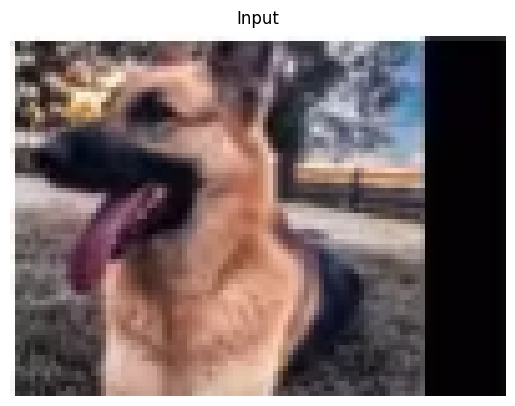

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔍 Face Detection Results:
  ✅ CNN Model: No-Face


In [9]:
# Run on a sample image
test_img_path = "test_images/sample6.png"
raw = cv2.imread(test_img_path)
rgb = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
plt.imshow(rgb); plt.title("Input"); plt.axis('off'); plt.show()

# Face detection via CNN-only example:
inp  = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype("float32")/255.0
inp  = inp.reshape(1, IMG_SIZE, IMG_SIZE, 3)
cnn_p = cnn_model.predict(inp)[0][0]
cnn_label = "Face" if cnn_p < 0.5 else "No-Face"

print("🔍 Face Detection Results:")
print(f"  ✅ CNN Model: {cnn_label}")

if cnn_label == "Face":
    print("\n🎭 Identity Prediction:")
    predict_user(test_img_path, threshold=0.7)

                 userId  wifi_count  avg_strength  kmeans_wifi_label  \
0                pratik           0      0.000000                  1   
1      parthmaynal.ec24          37    -72.837838                 13   
2      parthmaynal.ec24          11    -57.909091                  6   
3  akshatchauhan.co23d2           0      0.000000                  1   
4  akshatchauhan.co23d2           0      0.000000                  1   
5           keyurikj107           0      0.000000                  1   
6       hetvegad.co23d2           0      0.000000                  1   
7     naineshgurav.ec23          43    -75.000000                  2   
8           keyurikj107          57    -73.736842                  0   
9             202463002          35    -65.600000                  6   

   dbscan_wifi_label  agglo_wifi_label  
0                  0                 3  
1                  1                 0  
2                 -1                 0  
3                  0                 3  
4 

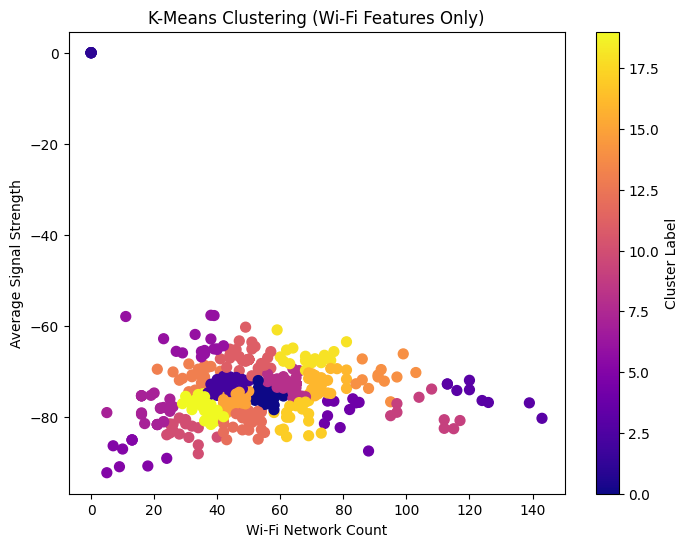

In [53]:
import pandas as pd
import json
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ===== Step 1: Load the JSON File Correctly =====
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)  # Use json.load() because it's NOT JSON lines

records = data['data']  # Access the actual list inside "data"

df = pd.json_normalize(records)

# ===== Step 2: Feature Engineering for Wi-Fi =====
df['wifi_count'] = df['wifiNetworks'].apply(lambda nets: len(nets))
df['avg_strength'] = df['wifiNetworks'].apply(
    lambda nets: sum(n['strength'] for n in nets) / len(nets) if nets else 0
)

# ===== Step 3: Select Only Wi-Fi Features =====
wifi_features = df[['wifi_count', 'avg_strength']].fillna(0)

# Normalize Wi-Fi features
scaler = StandardScaler()
scaled_wifi_features = scaler.fit_transform(wifi_features)

# ===== Step 4: Apply Clustering Algorithms (Wi-Fi) =====

# K-Means Clustering on Wi-Fi
kmeans_wifi = KMeans(n_clusters=20, random_state=42)
df['kmeans_wifi_label'] = kmeans_wifi.fit_predict(scaled_wifi_features)

# DBSCAN Clustering on Wi-Fi
dbscan_wifi = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_wifi_label'] = dbscan_wifi.fit_predict(scaled_wifi_features)

# Agglomerative Clustering on Wi-Fi
agglo_wifi = AgglomerativeClustering(n_clusters=5)
df['agglo_wifi_label'] = agglo_wifi.fit_predict(scaled_wifi_features)

# ===== Step 5: Show Cluster Assignments =====
print(df[['userId', 'wifi_count', 'avg_strength', 
          'kmeans_wifi_label', 'dbscan_wifi_label', 'agglo_wifi_label']].head(10))

# ===== Step 6: Visualize K-Means Wi-Fi Clustering =====
plt.figure(figsize=(8, 6))
plt.scatter(df['wifi_count'], df['avg_strength'], c=df['kmeans_wifi_label'], cmap='plasma', s=50)
plt.title("K-Means Clustering (Wi-Fi Features Only)")
plt.xlabel("Wi-Fi Network Count")
plt.ylabel("Average Signal Strength")
plt.colorbar(label='Cluster Label')
plt.show()


                 userId   latitude  longitude  kmeans_location_label  \
0                pratik  23.197520  72.608279                      1   
1      parthmaynal.ec24  21.182005  72.808192                      0   
2      parthmaynal.ec24  21.181995  72.808209                      0   
3  akshatchauhan.co23d2  21.182004  72.808191                      0   
4  akshatchauhan.co23d2  21.182004  72.808191                      0   
5           keyurikj107  21.182000  72.808192                      0   
6       hetvegad.co23d2  21.181974  72.808163                      0   
7     naineshgurav.ec23  21.181991  72.808209                      0   
8           keyurikj107  21.182000  72.808192                      0   
9             202463002  21.182011  72.808185                      0   

   dbscan_location_label  agglo_location_label  
0                     -1                     3  
1                      0                     2  
2                      0                     2  
3          

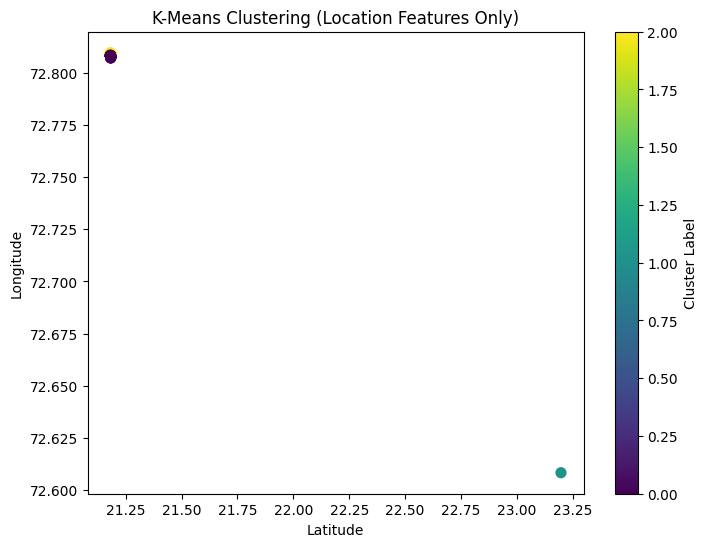

In [55]:
import pandas as pd
import json
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ===== Step 1: Load the JSON File Correctly =====
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

records = data['data']
df = pd.json_normalize(records)

# ===== Step 2: Select Location Features =====
location_features = df[['latitude', 'longitude']].fillna(0)

# Normalize Location features
scaler = StandardScaler()
scaled_location_features = scaler.fit_transform(location_features)

# ===== Step 3: Apply Clustering Algorithms (Location) =====

# K-Means Clustering (Location)
kmeans_location = KMeans(n_clusters=3, random_state=42)
df['kmeans_location_label'] = kmeans_location.fit_predict(scaled_location_features)

# DBSCAN Clustering (Location)
dbscan_location = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_location_label'] = dbscan_location.fit_predict(scaled_location_features)

# Agglomerative Clustering (Location)
agglo_location = AgglomerativeClustering(n_clusters=5)
df['agglo_location_label'] = agglo_location.fit_predict(scaled_location_features)

# ===== Step 4: Show Cluster Assignments =====
print(df[['userId', 'latitude', 'longitude', 
          'kmeans_location_label', 'dbscan_location_label', 'agglo_location_label']].head(10))

# ===== Step 5: Visualize K-Means Location Clustering =====
plt.figure(figsize=(8, 6))
plt.scatter(df['latitude'], df['longitude'], c=df['kmeans_location_label'], cmap='viridis', s=50)
plt.title("K-Means Clustering (Location Features Only)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label='Cluster Label')
plt.show()


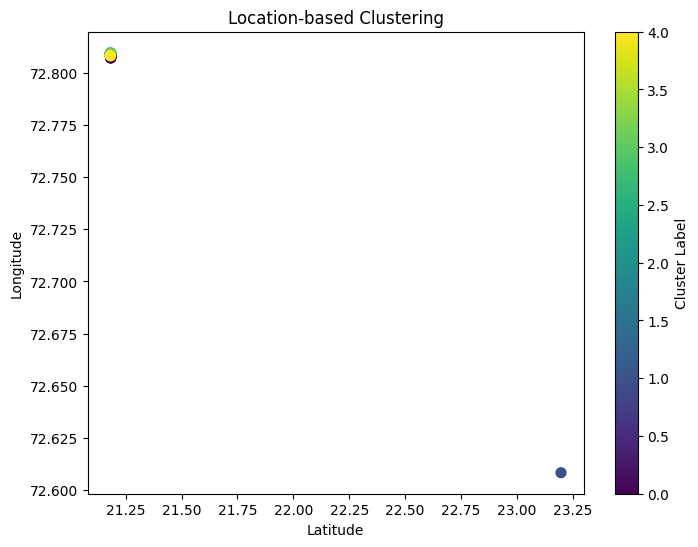

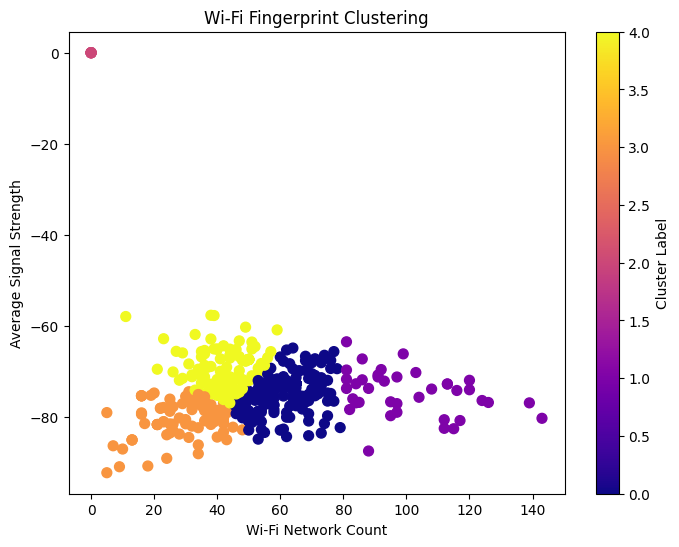

C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


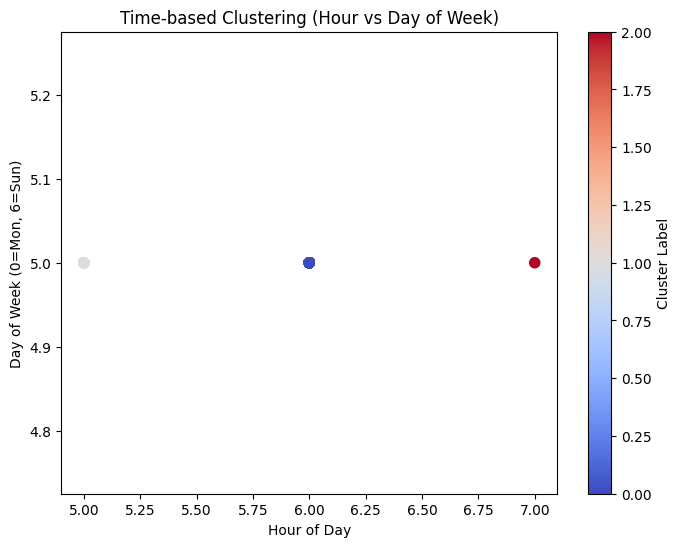

                 userId   latitude  longitude  wifi_count  avg_strength  hour  \
0                pratik  23.197520  72.608279           0      0.000000     5   
1      parthmaynal.ec24  21.182005  72.808192          37    -72.837838     5   
2      parthmaynal.ec24  21.181995  72.808209          11    -57.909091     5   
3  akshatchauhan.co23d2  21.182004  72.808191           0      0.000000     5   
4  akshatchauhan.co23d2  21.182004  72.808191           0      0.000000     5   
5           keyurikj107  21.182000  72.808192           0      0.000000     5   
6       hetvegad.co23d2  21.181974  72.808163           0      0.000000     5   
7     naineshgurav.ec23  21.181991  72.808209          43    -75.000000     5   
8           keyurikj107  21.182000  72.808192          57    -73.736842     5   
9             202463002  21.182011  72.808185          35    -65.600000     5   

   day_of_week  is_weekend  location_cluster  wifi_cluster  time_cluster  
0            5           1       

In [56]:
import pandas as pd
import json
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ===== Step 1: Load JSON Data =====
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

records = data['data']
df = pd.json_normalize(records)

# ===== Step 2: Wi-Fi Feature Engineering =====
df['wifi_count'] = df['wifiNetworks'].apply(lambda nets: len(nets))
df['avg_strength'] = df['wifiNetworks'].apply(
    lambda nets: sum(n['strength'] for n in nets) / len(nets) if nets else 0
)

# ===== Step 3: Time-based Feature Engineering =====
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# ================================================
# 🟢 1) LOCATION-BASED CLUSTERING
# ================================================
location_features = df[['latitude', 'longitude']].fillna(0)
scaled_loc = StandardScaler().fit_transform(location_features)

kmeans_loc = KMeans(n_clusters=5, random_state=42)
df['location_cluster'] = kmeans_loc.fit_predict(scaled_loc)

# Visualization
plt.figure(figsize=(8,6))
plt.scatter(df['latitude'], df['longitude'], c=df['location_cluster'], cmap='viridis', s=50)
plt.title("Location-based Clustering")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label='Cluster Label')
plt.show()

# ================================================
# 🟡 2) WI-FI FINGERPRINT CLUSTERING
# ================================================
wifi_features = df[['wifi_count', 'avg_strength']].fillna(0)
scaled_wifi = StandardScaler().fit_transform(wifi_features)

kmeans_wifi = KMeans(n_clusters=5, random_state=42)
df['wifi_cluster'] = kmeans_wifi.fit_predict(scaled_wifi)

plt.figure(figsize=(8,6))
plt.scatter(df['wifi_count'], df['avg_strength'], c=df['wifi_cluster'], cmap='plasma', s=50)
plt.title("Wi-Fi Fingerprint Clustering")
plt.xlabel("Wi-Fi Network Count")
plt.ylabel("Average Signal Strength")
plt.colorbar(label='Cluster Label')
plt.show()

# ================================================
# 🟠 3) TIME-BASED PATTERN CLUSTERING
# ================================================
time_features = df[['hour', 'day_of_week', 'is_weekend']]
scaled_time = StandardScaler().fit_transform(time_features)

kmeans_time = KMeans(n_clusters=4, random_state=42)
df['time_cluster'] = kmeans_time.fit_predict(scaled_time)

plt.figure(figsize=(8,6))
plt.scatter(df['hour'], df['day_of_week'], c=df['time_cluster'], cmap='coolwarm', s=50)
plt.title("Time-based Clustering (Hour vs Day of Week)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon, 6=Sun)")
plt.colorbar(label='Cluster Label')
plt.show()

# ================================================
# ✅ View Sample Results
# ================================================
print(df[['userId', 'latitude', 'longitude', 'wifi_count', 'avg_strength',
          'hour', 'day_of_week', 'is_weekend',
          'location_cluster', 'wifi_cluster', 'time_cluster']].head(10))


In [61]:
import pandas as pd
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# ===== Step 1: Load the JSON File =====
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

records = data['data']
df = pd.json_normalize(records)

# ===== Step 2: Feature Engineering =====
# Wi-Fi features
df['wifi_count'] = df['wifiNetworks'].apply(lambda nets: len(nets))
df['avg_strength'] = df['wifiNetworks'].apply(
    lambda nets: sum(n['strength'] for n in nets) / len(nets) if nets else 0
)

# Time-based features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Drop rows where 'location' is missing
df = df.dropna(subset=['location'])

# ===== Step 3: Prepare Features and Target =====
features = df[['latitude', 'longitude', 'wifi_count', 'avg_strength', 'hour', 'day_of_week']]
target = df['location']

# ===== Step 4: Remove Locations with Fewer Than 2 Records =====
location_counts = df['location'].value_counts()
valid_locations = location_counts[location_counts >= 2].index
df = df[df['location'].isin(valid_locations)]

# ===== NOW Prepare Features and Target =====
features = df[['latitude', 'longitude', 'wifi_count', 'avg_strength', 'hour', 'day_of_week']]
target = df['location']

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
# ===== Step 5: Scale Features =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===== Step 6: Train Random Forest Classifier =====
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# ===== Step 7: Evaluate Model =====
y_pred = rf.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ===== Step 8: Feature Importance =====
importances = rf.feature_importances_
feature_names = features.columns
print("\nFeature Importance:")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

# ===== BONUS: Predict Example =====
# Example input: replace with real test data if available
example_input = np.array([[23.197, 72.608, 10, -60, 10, 2]])  # Example: latitude, longitude, wifi_count, avg_strength, hour, day_of_week
example_input_scaled = scaler.transform(example_input)
predicted_location = rf.predict(example_input_scaled)
print(f"\nPredicted Location for Example Input: {predicted_location[0]}")


Classification Report:
                                 precision    recall  f1-score   support

                             04       0.00      0.00      0.00         1
                             06       1.00      1.00      1.00         1
                              1       1.00      1.00      1.00         1
                            102       0.25      1.00      0.40         1
                            106       1.00      1.00      1.00         1
                             12       0.00      0.00      0.00         1
                             15       0.00      0.00      0.00         1
                             17       0.00      0.00      0.00         1
                             18       0.00      0.00      0.00         1
                              2       0.80      1.00      0.89         4
                              3       0.00      0.00      0.00         1
                   Architecture       1.00      1.00      1.00         1
                           

C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\wwwja\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                 userId   latitude  longitude  kmeans_label  dbscan_label  \
0                pratik  23.197520  72.608279             1            -1   
1      parthmaynal.ec24  21.182005  72.808192             0             0   
2      parthmaynal.ec24  21.181995  72.808209             4             0   
3  akshatchauhan.co23d2  21.182004  72.808191             0             0   
4  akshatchauhan.co23d2  21.182004  72.808191             0             0   
5           keyurikj107  21.182000  72.808192             0             0   
6       hetvegad.co23d2  21.181974  72.808163             0             0   
7     naineshgurav.ec23  21.181991  72.808209             4             0   
8           keyurikj107  21.182000  72.808192             0             0   
9             202463002  21.182011  72.808185             0             0   

   agglo_label  
0            1  
1            2  
2            2  
3            2  
4            2  
5            2  
6            2  
7            2  

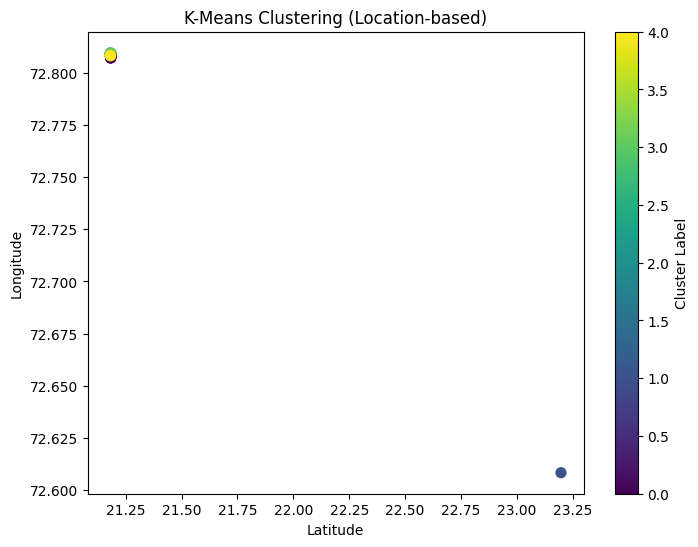

In [49]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your CSV file
df = pd.read_csv('data.csv')

# Select only the location features
features = df[['latitude', 'longitude']].fillna(0)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means Clustering

kmeans = KMeans(n_clusters=5, random_state=42)  # You can set 5, 6, 7... here
df['kmeans_label'] = kmeans.fit_predict(scaled_features)

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_label'] = dbscan.fit_predict(scaled_features)

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)
df['agglo_label'] = agglo.fit_predict(scaled_features)

# Show sample results
print(df[['userId', 'latitude', 'longitude', 'kmeans_label', 'dbscan_label', 'agglo_label']].head(10))


# Keep the visualization part the same:
plt.figure(figsize=(8,6))
plt.scatter(df['latitude'], df['longitude'], c=df['kmeans_label'], cmap='viridis', s=50)
plt.title("K-Means Clustering (Location-based)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label='Cluster Label')
plt.show()
